# Data Scientist Professional Practical Exam Submission


## Business Goal

The main objective of this business case is to be able to correctly predict popular recipes for the Tasty Byte web page i.e. which recipes will lead to high traffic, while trying to minimize the chance of showing unpopular recipes and be on target 80% of the times

## Python dependencies

We first need to import all the required python packages

In [1]:
# Imports

# Data Exploration and Manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt 

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#Other
import warnings
from sklearn.exceptions import DataConversionWarning

# 1. Data Validation

The dataset consist of 947 data samples/rows, and 8 columns. All the columns are described as follows: 
* _recipe_:  Numeric, unique identifier of recipe
* _calories_:  Numeric, number of calories
* _carbohydrate_:  Numeric, amount of carbohydrates in grams
* _sugar_:  Numeric, amount of sugar in grams
* _protein_:  Numeric, amount of protein in grams
* _category_:  Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal').
* _servings_:  Numeric, number of servings for the recipe
* _high_traffic_: Character, if the traffic to the site was high whe

## Dataset loading and info

Let's load the data and have a first look at it

In [2]:
recipe = pd.read_csv('recipe_site_traffic.csv', index_col= 'recipe')
n,d = recipe.shape 

In [3]:
recipe.head(30)

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN
6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN
9,538.52,3.78,3.37,3.79,Pork,6,High


We can also check the data types and the missing-values count

In [4]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


Based on the previous info, we will have to count the nulls in some columns

In [5]:
nanvalues = recipe.isna().sum()
nanvalues

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

We see that we have 52 missing values in the the columns `['calories', 'carbohydrate', 'sugar', 'protein']`, except for _high_traffic_ which will we treated separatedly. This is because _high_traffic_ nulls most probably represent the 'Low' class. It is good practice to always express this as a percentage of all data:

In [6]:
print(f'Percentage of null values: {nanvalues.calories/recipe.shape[0]*100}%' )

Percentage of null values: 5.4910242872228086%


Only **5%** of the total values are nulls (in each of the columns containing missing values) !!

Summary statistics are also always useful:

In [7]:
recipe.describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


We can check the nutrition facts per serving and compute it's summary statistic as well, and then compared it with recommended values:

In [8]:
nutrition_df = recipe.drop(columns = ['servings', 'high_traffic', 'category'])

nutrition_df_per_serving = nutrition_df.div(recipe.servings.str.replace(' as a snack','').astype(np.number), axis = 0)

nutrition_df_per_serving.describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,191.214301,14.904328,3.828301,10.451841
std,290.149519,24.894608,8.737914,18.917186
min,0.070000,0.007500,0.001667,0.000000
25%,33.693750,2.477500,0.541667,0.980417
50%,93.571667,6.940000,1.400000,3.340000
75%,225.240000,16.395000,3.768750,11.118750
max,2332.320000,383.060000,148.750000,182.630000


We can, for now, hypothesize that the dataset values are in the order of the nutrition facts reccomded values (Source: https://www.fda.gov/food/new-nutrition-facts-label/daily-value-new-nutrition-and-supplement-facts-labels), which mean that on average the recipes are healthy and nutritive dishes. We will confirm our hypothesis on the upcoming sections.

Note: we divided the daily values by 3 and 4, assuming 3-4 meals per day to make the comparison

## Actions to take
* Use _high_traffic_ as the target variable, since this variable will measuse 'popularity' of the recipe the best. 
* Assume all nulls in _high_traffic_ represent LOW traffic. Transform the columns using the mapping: {'High': 1, 'null':0}
* Impute the following columns: _calories, carbohydrate, sugar_, _protein_ (for nan values) and cast _servings_ to numeric types
* Analyze extreme values and decide what to do with these outliers

## Data cleaning and transformation

We can start with the targer variable first, by remapping the classes to binary values.

**High Traffic**

In [9]:
recipe.high_traffic = recipe.high_traffic.fillna(0) # Low
recipe.high_traffic = recipe.high_traffic.replace('High', 1) # High
recipe.high_traffic.astype('int32')
recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 59.2+ KB


_The rest of the columns will be imputed with the **median value**, since all of them are right-skewed distributions_ (this can be seen in the Data Visualization section that follows). The median values is always useful in these cases, since the mean is very sensitive to extreme values and the mode is more suitable for categorical data (or sometimes discrete numerical values) 

**Calories**

In [10]:
recipe.calories.fillna(recipe.calories.median(), inplace= True)
print(f'# Missing: {recipe.calories.isna().sum()}')
recipe.calories

# Missing: 0


recipe
1       288.55
2        35.48
3       914.28
4        97.03
5        27.05
        ...   
943    1161.00
944     288.55
945     951.74
946     266.61
947     184.56
Name: calories, Length: 947, dtype: float64

**Carbohydrate**

In [11]:
recipe.carbohydrate.fillna(recipe.carbohydrate.median(), inplace= True)

**Sugar**

In [12]:
recipe.sugar.fillna(recipe.sugar.median(), inplace= True)

**Protein**

In [13]:
recipe.protein.fillna(recipe.protein.median(), inplace= True)

**Servings**

We will cast this to a numerical type, but first we need to standarize all the values i.e. cleaning unwanted text before casting this column to a numerical type.

In [14]:
recipe.servings.unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [15]:
recipe.servings = recipe.servings.str.replace(' as a snack','')
recipe.servings.unique()

array(['6', '4', '1', '2'], dtype=object)

In [16]:
recipe.servings = pd.to_numeric(recipe.servings) 
recipe.servings.info()

<class 'pandas.core.series.Series'>
Int64Index: 947 entries, 1 to 947
Series name: servings
Non-Null Count  Dtype
--------------  -----
947 non-null    int64
dtypes: int64(1)
memory usage: 14.8 KB


**Category**

We can check that there is no issues with this column in particular

In [17]:
print(f'# Categories: {len(recipe.category.unique())}')
recipe.category.unique()

# Categories: 11


array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

## Outliers

We will analyze the portion of outliers in the aforementioned columns, to see if it is worth removing them.

We will use the 'interquartile range' technique, implemente in the `get_outliers` function.

In [18]:
def get_outliers(arr):
    
    q1 = np.quantile(arr, q = 0.25)
    q3 = np.quantile(arr, q = 0.75)
    iqr = q3 - q1
    
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    # print(f'(Upper,Lower) limits: {upper, lower}' )
    
    return arr[ (arr > upper) | (arr < lower)]

We can use the function above to get the percentage of outliers per columns, and determine if this will affect our later analysis or not. 

In [19]:
p_out = []
out_cols = list(recipe.select_dtypes(include= np.number).columns)

for i,c in enumerate(out_cols):
    n_out = len(get_outliers(recipe[c]))
    p_out .append(n_out/n*100)
    print(f'[{c}] % outliers: {p_out[i]}')

[calories] % outliers: 6.124604012671594
[carbohydrate] % outliers: 6.9693769799366425
[sugar] % outliers: 8.658922914466736
[protein] % outliers: 9.292502639915522
[servings] % outliers: 0.0
[high_traffic] % outliers: 0.0


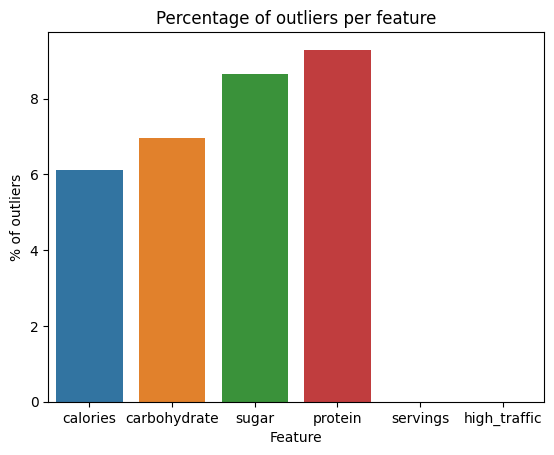

In [20]:
ax = sns.barplot(x = out_cols, y = p_out)
ax.set_title('Percentage of outliers per feature')
_ = ax.set_xlabel('Feature')
_ = ax.set_ylabel('% of outliers')


All of them are under 10%. We can leave the columns as they are for the time being 

In [21]:
recipe.head(30)

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,288.55,21.48,4.55,10.80,Pork,6,1
2,35.48,38.56,0.66,0.92,Potato,4,1
3,914.28,42.68,3.09,2.88,Breakfast,1,0
4,97.03,30.56,38.63,0.02,Beverages,4,1
5,27.05,1.85,0.80,0.53,Beverages,4,0
6,691.15,3.46,1.65,53.93,One Dish Meal,2,1
7,183.94,47.95,9.75,46.71,Chicken Breast,4,0
8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,0
9,538.52,3.78,3.37,3.79,Pork,6,1


## Final Validation

In [22]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      947 non-null    float64
 1   carbohydrate  947 non-null    float64
 2   sugar         947 non-null    float64
 3   protein       947 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 59.2+ KB


In [23]:
recipe.isna().sum()

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

## **Summary**
- We defined our target to be: '`high_traffic We transformed this column using the following mapping: `{'High': 1, 'null':0}`. 
- From the previous point, we can conclude that this is a *binary classification problem*, so we will treated accordingly from now in order to get the right predictions
- Our feature columns are: `['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']`
- We cleaned out all missing values -> Imputation with the median
- We cleaned and casted the servings column to numeric.
- We concluded that since %outliers < 10 for each columns of interest, we would leave them as is.

# 2. Data Visualization

We will use _high_traffic_ as the target column here. 

## Target variable

Let's see the balance of the classes. This is useful to determine what model will perform better and with which metric to evaluate its performance later on.

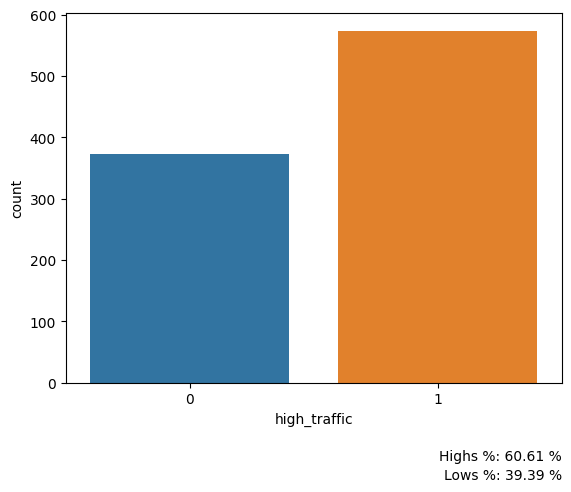

In [24]:
ax = sns.countplot( data = recipe, x = 'high_traffic')

_ = ax.annotate(f'Highs %: {np.round(len(recipe.high_traffic[recipe.high_traffic == 1])/n*100,2)} %', 
                xy = (1,-0.2),
                xycoords='axes fraction',
                ha='right',
                va="center",
                fontsize=10)

_ = ax.annotate(f'Lows %: {np.round(len(recipe.high_traffic[recipe.high_traffic == 0])/n*100,2)} %', 
                xy = (1,-0.25), 
                xycoords='axes fraction',                  
                ha='right',
                va="center",
                fontsize=10)

This is an interesting plot to see that there is *no imbalance* between negative and positive classes !!

Also, let's try so see if there is linear correlation between variables first, to also help determine which model will eventually be selected for our classification problem.

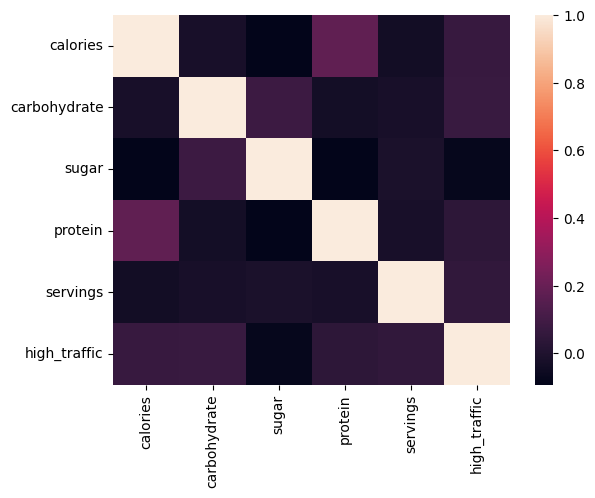

In [25]:
_ = sns.heatmap(recipe.corr())

There is clear no linear correlation among variables. There should be another type if relationship behind the variables. We can later experiment if the classification model will be able to find out the underlying relationships in the data

## Features

Let's visualize the distribution of some of the features. 


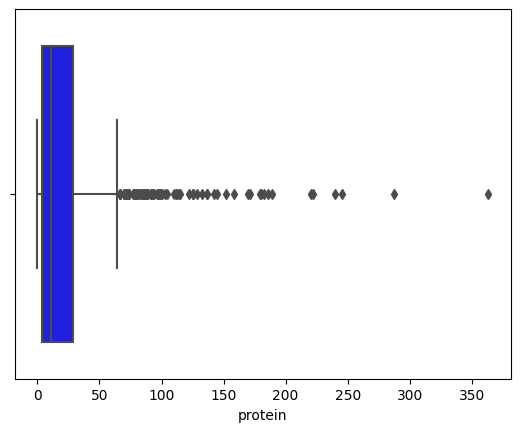

In [26]:
# Sugar
_ = sns.boxplot(data = recipe, x = 'protein', color = 'b')

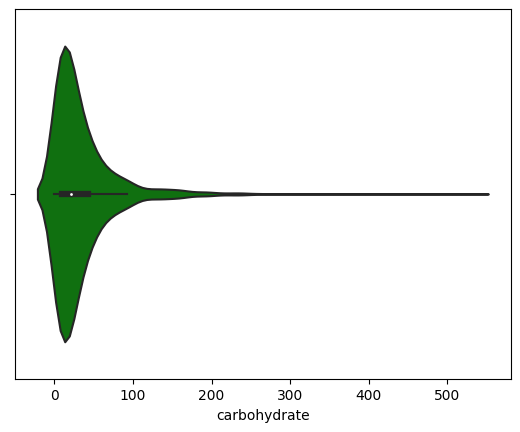

In [27]:
# Carbohydrates
_ = sns.violinplot(data = recipe, x = 'carbohydrate', color = 'g')

We see that it appears to be some outliers. However, based on the analysis performed in the _**1. Data Validation: Outliers**_ subsection, we determine that all of them are under 10% with respect to the total number of samples. Thus, we can ignore them in this case.

We can also distinguish the nutritional facts distributions by `category`, and see if there are any significant differences among them. Here we used `calories`

427.8460190073918


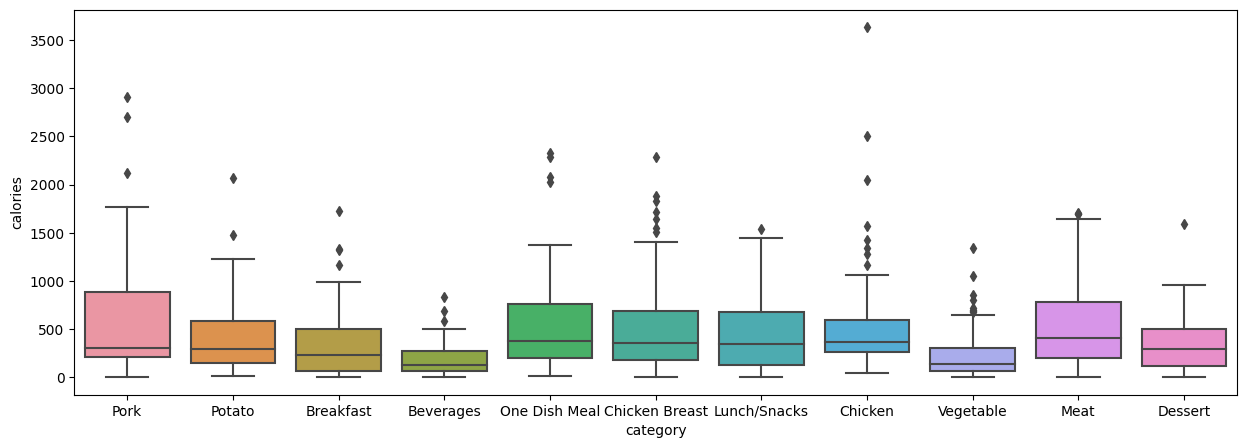

In [28]:
# Calories by category
print(recipe.calories.mean())
fig, ax = plt.subplots(1,1,figsize=(15,5))
_ = sns.boxplot(data = recipe, y = 'calories', x = 'category', ax = ax)

Even for differente categories, the calories distriburion are not too disimilar. If you compare their medians you will be able to see that they even are in the same order (~ less than 500)

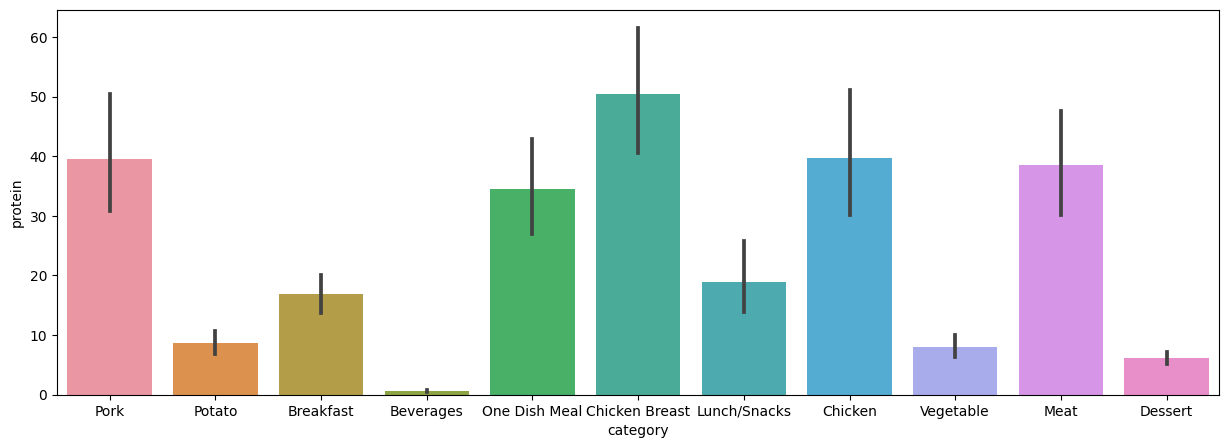

In [29]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
_ = sns.barplot(data = recipe, x = 'category', y = 'protein', ax = ax)

We can use a pairplot to see the relationship among all features at once

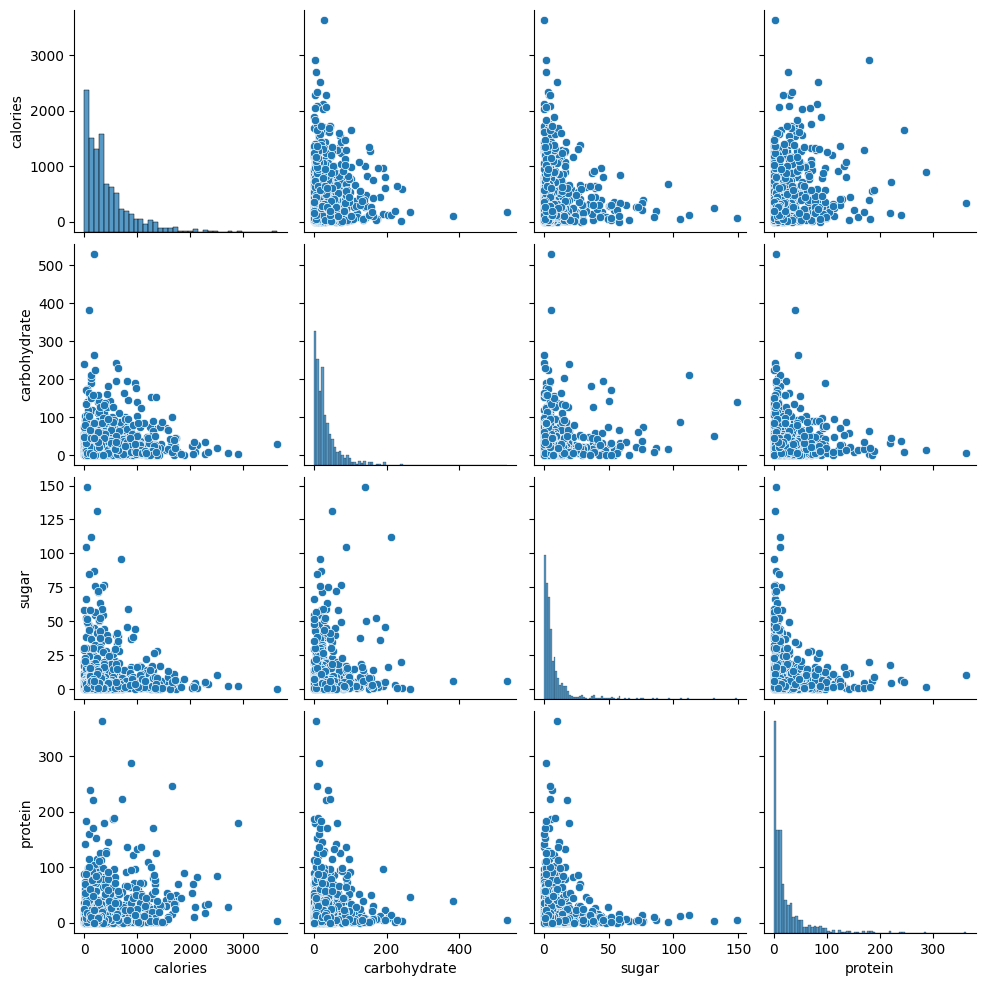

In [30]:
_ = sns.pairplot(data = recipe[['calories', 'carbohydrate', 'sugar', 'protein']])

This plot confirms our hyphotesis of the dishes being healthy: this can be justified with the fact that all the points in the scatterpplots in the figure are grouped in the bottom-left corner of the chart in general i.e. there is a tendency of the nutrition values to be low in general.

## **Summary**
* Most of the recipes are healthy and balanced: low carbs, sugar and decent levels of calories and a good level of proteins
* There are only some outliers (they have been calculated to be less than 10% for any feature)
* There is a good balance of nutritional features between recipe categories.

# 3. Data Preprocessing

## Feature engineering

* **Categorical Variables**: we will one-hot encode the following categorical variables: _`category`_
* **Numerical Variables**: we use RobustScaler() for numerical variables `['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']`

In [31]:
X = recipe.drop(columns = ['high_traffic'])
y = recipe.high_traffic

In [32]:
# Categorical columns
cat_columns = X.select_dtypes(include = 'object').columns.tolist()
# Numerical columns
num_columns = X.select_dtypes(include = [np.number]).columns.tolist()

Now that we have our dataset cleaned and ready to analyze, we will split our data into training and test sets

**Train-test split**

Given that we don't have too many data samples to train on, instead of the usual 80-20 train-test split, we decide to go with a 85-15 split since we thought this will yield better results.

In [33]:
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state = 0)

**Encoder & Scaler**

Now it's time to one-hot encode our categorical variables and scaled our numerical features. We decided to make use of sklearn's `ColumnTransformer` for this task and then fitted the data to it. The outputs of this process are stored in the arrays `X_train_enc` and `X_test_enc` respectively. 

In [34]:
# Encoders
cat_enc = OneHotEncoder(drop = 'first', handle_unknown= 'ignore')

# Scaler
scaler = RobustScaler()

# Column tranformer
transformer = ColumnTransformer( transformers = [
                                ('onehot', cat_enc, cat_columns),
                                ('scaler', scaler, num_columns)
                                ])

# Fit-transform data
transformer.fit(X_train)
X_train_enc = transformer.transform(X_train)
X_test_enc = transformer.transform(X_test)

In [35]:
X_train_enc.shape

(804, 15)

# 4. Model Selection

We want to predict the binary target variable `high_traffic`. Hence we will need a **classifier model**. We have experimented with the following models:
1. **Baseline**: Random Forest Classifier
2. **First approach**: Gradient Boosting Classifier
3. **Best chosen**: Logistic Regression


## Baseline

Random Forest Classifier usually gives out pretty good results, especially to discover non-linear relationships among different features of the data. We trained it as the baseline model because it usually is a good first choice.

In [36]:
# rf_params = {'max_depth': 25, 'min_samples_split': 25, 'n_estimators': 125}

rf= RandomForestClassifier().fit(X_train_enc, y_train)

## LightGBM

Antoher classifier that usually has great performance, is the LightGBM. We have fined-tuned it using _GridSearch cross validation_ and obtained the best parameters. We will use these directly for training

In [37]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

######################################################################################################
# Hyperparameter-tuning
######################################################################################################

# lgb_params = {
#     'objective': ['binary'],
#     'metric': ['accuracy'],
#     'num_iterations': [  1500, 2000  ],
#     'learning_rate':[  0.05, 0.005 ],
#     'num_leaves':[ 7, 10, 15, 30],
#     'max_depth' :[ 10,15,25],
#     'min_data_in_leaf':[15,25 ],
#     'feature_fraction': [ 0.6, 0.8],
#     'bagging_fraction': [  0.6, 0.8 ],
#     'bagging_freq': [   100, 200  ],    }

# lgbm_grid_clf = GridSearchCV(LGBMClassifier(), param_grid= lgb_best_params, cv = 6, n_jobs= -1)
######################################################################################################

# Best after fine-tuning:
lgbm_best_params = {'bagging_fraction': 0.6,
                    'bagging_freq': 100,
                    'feature_fraction': 0.6,
                    'learning_rate': 0.005,
                    'max_depth': 10,
                    'metric': 'accuracy',
                    'min_data_in_leaf': 15,
                    'num_iterations': 1500,
                    'num_leaves': 7,
                    'objective': 'binary'}


lgbm = LGBMClassifier(**lgbm_best_params).fit(X_train_enc, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


##  Logistic Regression

Lastly (and after some experimentation) we have discovered that the Logistic Regression is the model that outperforms the others (but not by much). We have also fined-tuned it using _GridSearch with cross validation_ and 8 folds.

In [38]:
# Parameters
logit_params = { 'penalty': ['l1', 'l2'], 'tol': [0.0005, 0.0001, 0.0005, 0.001], 'C': [0.5,1,1.5,2], 'max_iter': [500,1000,1500]}

# GridSearch + CrossValidation
grid_logit = GridSearchCV(estimator = LogisticRegression() , param_grid= logit_params, cv = 8, n_jobs= -1)

# Fit best model
logit = grid_logit.fit(X_train_enc, y_train)

In [39]:
grid_logit.best_params_

{'C': 2, 'max_iter': 500, 'penalty': 'l2', 'tol': 0.0005}

# 5. Model Evaluation

We will use two metrics for comparison:
* **Precision**: This will tell how precise our algorithm is in predicting popular recipes. It's the main metric used because we can determine how well our algorithm is performing in predicting the true positives (recipes with high traffic) while minimizing false positives.
* **Other**: _[ROC-AUC score, accuracy, recall]_ these metrics are used in many classifiers algorithms. It's always important to keep track of them along with the main metric used.

In [40]:
target_names = ['High', 'Low']

## RandomForest

In [41]:
y_pred_rf= rf.predict_proba(X_test_enc)[:,1]
rf_roc_auc_score = roc_auc_score(y_test, y_pred_rf)
print(f'AUC score: {rf_roc_auc_score}')

AUC score: 0.769766957969205


In [42]:
print(classification_report(y_test, rf.predict(X_test_enc), target_names= target_names))

              precision    recall  f1-score   support

        High       0.59      0.61      0.60        54
         Low       0.76      0.74      0.75        89

    accuracy                           0.69       143
   macro avg       0.67      0.68      0.68       143
weighted avg       0.69      0.69      0.69       143



Precision: 0.76
Accuracy: 0.69
Recall: 0.74


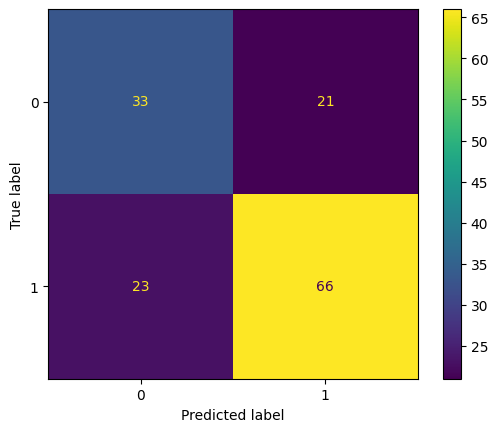

In [43]:
y_pred_rf= rf.predict(X_test_enc)
prec_rf = round(precision_score(y_test, y_pred_rf),2)
acc_rf = round(accuracy_score(y_test, y_pred_rf),2)
rec_rf = round(recall_score(y_test, y_pred_rf),2)

print(f'Precision: {prec_rf}')
print(f'Accuracy: {acc_rf}')
print(f'Recall: {rec_rf}')

cm = confusion_matrix(y_test, rf.predict(X_test_enc) )
_ = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= rf.classes_).plot()

## LightGBM

In [44]:
y_pred_lgbm= lgbm.predict_proba(X_test_enc)[:,1]
lgbm_roc_auc_score = roc_auc_score(y_test, y_pred_lgbm)
print(f'AUC score: {lgbm_roc_auc_score}')

AUC score: 0.7856845609654598


Precision: 0.81
Accuracy: 0.74
Recall: 0.76


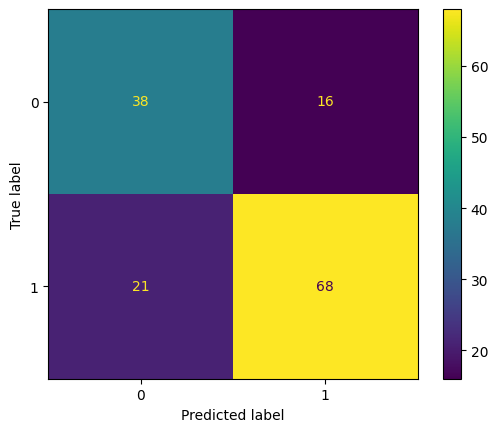

In [45]:
y_pred_lgbm= lgbm.predict(X_test_enc)
prec_lgbm = round(precision_score(y_test, y_pred_lgbm),2)
acc_lgbm = round(accuracy_score(y_test, y_pred_lgbm),2)
rec_lgbm = round(recall_score(y_test, y_pred_lgbm),2)

print(f'Precision: {prec_lgbm}')
print(f'Accuracy: {acc_lgbm}')
print(f'Recall: {rec_lgbm}')

cm = confusion_matrix(y_test, lgbm.predict(X_test_enc) )
_ = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= rf.classes_).plot()

## Logistic Regression

In [46]:
y_pred_logit_proba= logit.predict_proba(X_test_enc)[:,1]
logit_roc_auc_score = roc_auc_score(y_test, y_pred_logit_proba)
print(f'AUC score (Logistic): {logit_roc_auc_score}')

AUC score (Logistic): 0.8341656263004578


Precision: 0.81
Accuracy: 0.76
Recall: 0.79


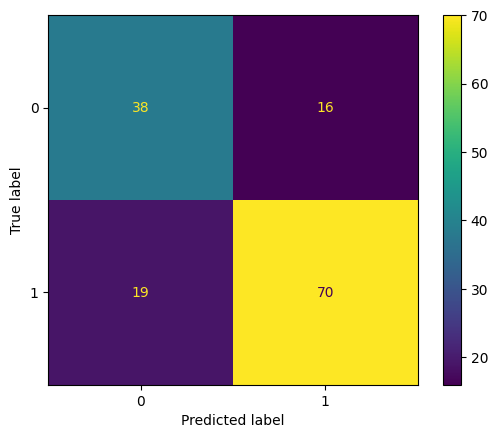

In [47]:
y_pred_logit= logit.predict(X_test_enc)
prec_logit = round(precision_score(y_test, y_pred_logit),2)
acc_logit = round(accuracy_score(y_test, y_pred_logit),2)
rec_logit = round(recall_score(y_test, y_pred_logit),2)

print(f'Precision: {prec_logit}')
print(f'Accuracy: {acc_logit}')
print(f'Recall: {rec_logit}')

cm = confusion_matrix(y_test, logit.predict(X_test_enc) )
_ = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= logit.classes_).plot()

## Top 10 Most Popular recipes

We could use the probabilities predicted by our LogisticRegression model to predict the most popular recipes also. We can evaluate it in the test dataset as an example, as follows:

In [48]:
data = {'recipe': y_test.index,'target': y_pred_logit,'prob': y_pred_logit_proba }
recipes_prob = pd.DataFrame(data = data)

# We will sort the recipes now
top_10_recipes = recipes_prob.nlargest(columns = ['prob'],n=10).drop(columns=['target'])
top_10_recipes.set_index(['recipe'], inplace = True)
top_10_recipes

,prob
recipe,
102,0.964433
692,0.958110
633,0.956199
539,0.955002
835,0.954893
232,0.954503
367,0.954220
373,0.954116
821,0.952627


## Methodology

We have treated the problem as a binary classification problem, with `high_traffic` as the target variable and the rest as the dependent variables, where we had both numeric and categorical variables.
We have converted all categorical to numeric ones (through One-Hot Encode technique) to fit all the data to a classification model suitable for the business case. 

We chose a **_Logistic Regression_** among all because of it's performance. With the model, we can make predictions about the popularity of the recipe displayed on the homepage with high precision*

*_Results will be presented in the following subsections_

In [49]:
metrics = {'Classifier': ['RandomForest','LightGBM','LogisticRegression'], 
        'Precision': [prec_rf,prec_lgbm,prec_logit], 
        'Accuracy': [acc_rf,acc_lgbm,acc_logit], 
        'Recall': [rec_rf,rec_lgbm,rec_logit], 
        'AUC-ROC': [rf_roc_auc_score,lgbm_roc_auc_score,logit_roc_auc_score]}

results_table = pd.DataFrame(data = metrics).set_index('Classifier')

## Metrics - KPI

The business criteria was to estimate which recipes will have have traffic 80% of the time. Since the exercise required a classification problem, the target classes were balanced and we also we wanted to minimize the chance of showing unpopular recipes (i.e. minimizing false positives), we have chosen **_precision_** as the main metric to evaulate model performance. 

With a model chosen, we can even now what the probability is for each recipe. If we choose a recipe that will be  popular with high probability, there will also a high chance of high traffic. Under this assumption, one extra thing we could do is measure the true traffic level (or the increase in traffic by default) and defined this number a the *_**KPI**_* for this use case. Unfortunately, since we don't have that information in our dataset, we will have to stick to _precision_ to decide between 'popular' and 'not popular' recipes.


Additionally, we supported our analysis on other concepts like the _confusion matrix_, _accuracy_, _recall_ and the _AUC-ROC score_ (Area under the ROC curve). 

At the end, we could report a **KPI/precision of  81%**  after the evaluation of our **_Logistic Regression model_**. 
The results will be summarized better in the next section.

## Conclusions:

* The three models (including the RandomForestClassifier) used for the classification problem perform well in general. However, we had to stick to the Logistic Regression for perfomance reasons. 
* We managed to achieved the required goal proposed (high precision, low number of False Positives)
* We have summamrized the results  in the following table (for all three models):
> _Note: All these results were from the evaluation on the test set._

In [50]:
results_table

,Precision,Accuracy,Recall,AUC-ROC
Classifier,,,,
RandomForest,0.76,0.69,0.74,0.769767
LightGBM,0.81,0.74,0.76,0.785685
LogisticRegression,0.81,0.76,0.79,0.834166


## Recommendations
* It is much better to rely on this classification model that can predict what recipes will be popular wiht a high precision _instead of having the product manager do it manually_. _Conclusion:_ The forecast process can be easily **automated** on the backend of our web page to display the right recipe in order to rise the website traffic.
* A great variable to measure and capture from now on should be the _increase in traffic level_ when a popular recipe is displayed. This will allow us to define a clear **_KPI_** for this problem.
* If we colud get more recipe data samples or try to include more features (like other nutrition facts, recipe origin, time of preparation, **number of clicks**, etc.), that will help us fine-tune the model better and thus obtain an even better performance than the current one.